### Deep Q Learning for Atari Game -- Pong-v0
#### by Yuen Nam YEUNG

Pong was a simulating game of table tennis. A ball was set to move and bounce in a box. Players control a pad to rebound the ball in order to avoid the ball to fall on their side. If the ball fell on the ones side, the opponent won a point. The winner would be the one who gained 21 points first.
The Pong environment was provided by OpenAI [1]. The package called Gym provided the RGB screen which was an (210,160,3) array and the actions of the agent could be either UP or DOWN given that the computer player only moved Up and Down periodically. At the beginning of each point, the ball was set to start at the centre and moved towards the one who just lost. 

### Import all the libraries

In [1]:
%matplotlib inline
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
from IPython.display import clear_output
from time import sleep

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

#import the Pong environment
env = gym.make('Pong-v0').unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Deep Q Learning
In the Pong environment, there were 2 main problems of using Q learning. Firstly, the numerous different state-action combinations made it impossible to create the R-Matrix in advance. Secondly, the ineffective caused by the sparseness of the rewards given to the actions.

In Deep Q Learning, a neural network was used to approximate the Q value function. It was a combination of Deep Learning (DL) and Q-Learning. In each step, image of the screen (as the state) was inputted to a neural network and getting output as the probability of actions (Q-value). In this part, 2 different networks were compared. 
![title](DQN.png)

### Replay Memory

Positive Reward Boosted Experience Replay


The states-action-reward experience was stored in the replay memory for updating the policy network. However, at the beginning of the training, the ratio of positive reward transitions to negative reward transitions was very small (about 2%). The randomly picked experience from the replay memory would not include enough positive experience which meant the policy was not updated efficiently. For this, the random sampling was replaced by separating positive and negative rewards transitions random sampling. At the beginning of the training, at least 20% of the positive rewards were drawn for each batch. The sampling positive ratio increased exponentially when the training went by.

In [2]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
    
    #Save new transition
    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
            self.memory[-1] = Transition(*args)
        if self.position >= self.capacity:
            del self.memory[0]
            self.memory.append(None)
            self.memory[-1] = Transition(*args)
        self.position += 1
    
    #Sampling with Positive Reward Boosted
    def sample(self, batch_size, positive_ratio):
        self.positive_rewards = []
        self.negative_rewards = []
        for i in range(len(self.memory)):
            if self.memory[i][3] > 0:
                self.positive_rewards.append(self.memory[i])    
            else:
                self.negative_rewards.append(self.memory[i])
        
        if len(self.positive_rewards) < round(positive_ratio*batch_size):
            self.positive_rewards += random.sample(self.negative_rewards,
                                                   round(positive_ratio*batch_size)-len(self.positive_rewards))
       
        self.positive_rewards = random.sample(self.positive_rewards, round(positive_ratio*batch_size))
        self.negative_rewards = random.sample(self.negative_rewards, round((1-positive_ratio)*batch_size))
            
        return self.positive_rewards + self.negative_rewards

    def __len__(self):
        return len(self.memory)

### Extraction of Screen

Original Size of the screen:

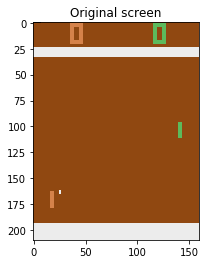

Shape of Screen:(210, 160, 3)


In [3]:
env.reset()
for _ in range(40):
    env.step(1)
screen = env.render(mode='rgb_array')
plt.imshow(screen, interpolation='none')
plt.title('Original screen')
plt.show()
print('Shape of Screen:{}'.format(screen.shape))

Preprocessing and state defining


The original screen pixel shape was (210,160,3). Some irrelevant pixels were cropped out. The remaining pixel shape was (160,160,3). The colour of the image was not important for deciding the actions, thus the screen was further decolour to form black and white single channel. The image was then resized to (80,80,1) which was shown in figure 12. For more efficient learning, the state was set to the difference of the current screen and last screen instead of concatenating of the screens. This could save half of the computation cost.

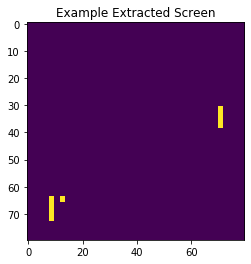

Shape of Screen:torch.Size([1, 1, 80, 80])


In [4]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(80, interpolation=Image.CUBIC),
                    T.ToTensor()])
def get_screen():
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    screen = screen[0, 34:194,:]
    screen[screen == 144] = 0
    screen[screen == 109] = 0
    screen[screen != 0] = 1
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0).to(device)

def plot_gray_screen(gray_screen):
    screen = gray_screen.cpu().squeeze(0).numpy().reshape(80,80)
    plt.imshow(screen, interpolation='none')
    plt.title('Example Extracted Screen')
    plt.show()

def plot_screen(rgb_screen):
    plt.imshow(rgb_screen.cpu().squeeze(0).numpy().reshape(80,80,3),
              interpolation='none')
    plt.title('Example Extracted Screen')
    plt.show()    
    
screen = get_screen()
plot_gray_screen(screen)
print('Shape of Screen:{}'.format(screen.shape))

### Selecting Actions
Epsilon-greedy policy was used here

In [5]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(2)]], device=device, dtype=torch.long)

### Optimizer Setup

In [6]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE, positive_ratio)
    
    # Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.mse_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

### Deep Neural Network 
In this report,2 different Network structures were tested:
1.	Linear Network
The input state preprocessed so that they simply contained zeros and ones. It was worth trying a simple network as the baseline model. One hidden layer network of 200 neurons with ReLu activation function was used.
2.	Convolutional Neural Network (CNN)
A 3 layers model of CNN was used. All the three layers were used with kernel of 5 and stride of 2. First, second and third layer used 16, 32 and 4 filters correspondingly. Batch Normalization was carried out in each layer. 

In [ ]:
#Linear Network
class DQN(nn.Module):
    def __init__(self, h, w):
        super().__init__()  
        self.fc1 = nn.Linear(in_features=h*w*1, out_features=200)   
        self.out = nn.Linear(in_features=200, out_features=2)
    
    def forward(self, t):
        t = t.flatten(start_dim=1)
        t = F.relu(self.fc1(t))
        t = self.out(t)
        return t

In [7]:
#CNN network
class DQN(nn.Module):

    def __init__(self, h, w):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 4, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(4)

        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 4
        self.head = nn.Linear(linear_input_size, 2)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

### Hyperparameters and Initialization

Sparseness of positive rewards samples at the beginning posed a big challenge for the training. Besides the epsilon-greedy policy, throughout the training process, different sets of hyperparameters were assigned for 2 stages of training. The first stage was the exploration stage. In this stage, the hyperparameters where set to explore the environment. It aimed at collecting more positive rewards transitions. The second stage was the exploitation stage. After gathering useful transitions, the agent could act more aggressively in this stage. 

In [10]:
#Initialize all the hyperparameters
BATCH_SIZE = 256
learning_rate = 0.0005
GAMMA = 0.7
EPS_START = 0.5
EPS_END = 0.01
EPS_DECAY = 500
TARGET_UPDATE = 10
discount_reward = 0.98
positive_ratio = init_positive_ratio = 0.5
ratio_decay = 0.006
cum_rewards=[]
cum_steps=[]

#Initialize the initial screen
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

#Inilialize the policy Net and Target Net
policy_net = DQN(screen_height, screen_width).to(device)
target_net = DQN(screen_height, screen_width).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
print(target_net)

#Define the Optimizer and initialize the replay memory
optimizer = optim.RMSprop(policy_net.parameters(),lr=learning_rate)
memory = ReplayMemory(50000)

In [ ]:
#Train from Load Model
#Initialize all the hyperparameters
BATCH_SIZE = 256
learning_rate = 0.0005
GAMMA = 0.7
EPS_START = 0.5
EPS_END = 0.01
EPS_DECAY = 500
TARGET_UPDATE = 10
discount_reward = 0.98
positive_ratio = init_positive_ratio = 0.5
ratio_decay = 0.006
cum_rewards=[]
cum_steps=[]

#Load the model
save_name = 'v7_mac_by_v6weight'
checkpoint = torch.load(save_name + '.pt',map_location=torch.device('cpu'))

#Initialize the initial screen
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

#Inilialize the policy Net and Target Net
policy_net = DQN(screen_height, screen_width).to(device)
target_net = DQN(screen_height, screen_width).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
print(target_net)

#Define the Optimizer and initialize the replay memory
optimizer = optim.RMSprop(policy_net.parameters(),lr=learning_rate)
memory = ReplayMemory(50000)

### Training Loop

In [11]:
num_episodes = 5000
for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    if i_episode>=1:
        positive_ratio = 1-(1-init_positive_ratio)*math.exp(-1. * (i_episode-39)*ratio_decay)
    rewards = 0
    store_t = 0
    steps_done = 0
    for t in count():
        # Select and perform an action
        if i_episode <=1:
            steps_done = t
            action = torch.tensor([[random.randrange(2)]], device=device, dtype=torch.long)
        else:
            action = select_action(state)
        _, reward, done, _ = env.step(action+2)
        rewards += reward
        reward = torch.tensor([reward], device=device)
        
        #discounted rewards
        if reward == -1:
            diff_t = t - store_t
            for i in range(5,diff_t):
                memory.memory[-1*i] = memory.memory[-1*i]._replace(reward = torch.ones((1),device = device)*(-1)*discount_reward**(i-5))
            store_t = t
        elif reward == 1:
            diff_t = t - store_t
            for i in range(45,diff_t):
                memory.memory[-1*i] = memory.memory[-1*i]._replace(reward = torch.ones((1),device = device)*1*discount_reward**(i-45))
            store_t = t
            
        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform optimization (on the target network)
        if reward == -1 or reward == 1:
            optimize_model()
        if done:
            break
    print('Episode:{}/{}, Rewards={}, Steps={}'.format(i_episode+1,num_episodes,rewards,steps_done))
    cum_rewards.append(rewards)
    cum_steps.append(steps_done)
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')

Episode:1/5000, Rewards=-21.0, Steps=1095
Episode:2/5000, Rewards=-21.0, Steps=1169
Episode:3/5000, Rewards=-21.0, Steps=1488
Episode:4/5000, Rewards=-21.0, Steps=1482
Episode:5/5000, Rewards=-21.0, Steps=1500
Episode:6/5000, Rewards=-20.0, Steps=1217
Episode:7/5000, Rewards=-19.0, Steps=1279
Episode:8/5000, Rewards=-20.0, Steps=1220
Episode:9/5000, Rewards=-19.0, Steps=1370
Episode:10/5000, Rewards=-21.0, Steps=1017
Episode:11/5000, Rewards=-21.0, Steps=1013
Episode:12/5000, Rewards=-21.0, Steps=1266
Episode:13/5000, Rewards=-19.0, Steps=1769
Episode:14/5000, Rewards=-21.0, Steps=1272
Episode:15/5000, Rewards=-21.0, Steps=1262
Episode:16/5000, Rewards=-20.0, Steps=1407
Episode:17/5000, Rewards=-21.0, Steps=1189
Episode:18/5000, Rewards=-19.0, Steps=1435
Episode:19/5000, Rewards=-20.0, Steps=1466
Episode:20/5000, Rewards=-21.0, Steps=1197
Episode:21/5000, Rewards=-21.0, Steps=1506
Episode:22/5000, Rewards=-21.0, Steps=1039
Episode:23/5000, Rewards=-21.0, Steps=1166
Episode:24/5000, Rew

Episode:190/5000, Rewards=-21.0, Steps=1178
Episode:191/5000, Rewards=-20.0, Steps=1383
Episode:192/5000, Rewards=-20.0, Steps=1237
Episode:193/5000, Rewards=-21.0, Steps=1270
Episode:194/5000, Rewards=-18.0, Steps=1626
Episode:195/5000, Rewards=-20.0, Steps=1562
Episode:196/5000, Rewards=-21.0, Steps=1189
Episode:197/5000, Rewards=-20.0, Steps=1559
Episode:198/5000, Rewards=-21.0, Steps=1199
Episode:199/5000, Rewards=-17.0, Steps=1864
Episode:200/5000, Rewards=-20.0, Steps=1458
Episode:201/5000, Rewards=-20.0, Steps=1323
Episode:202/5000, Rewards=-16.0, Steps=2068
Episode:203/5000, Rewards=-20.0, Steps=1309
Episode:204/5000, Rewards=-21.0, Steps=1642
Episode:205/5000, Rewards=-21.0, Steps=1746
Episode:206/5000, Rewards=-21.0, Steps=1242
Episode:207/5000, Rewards=-21.0, Steps=1341
Episode:208/5000, Rewards=-21.0, Steps=1654
Episode:209/5000, Rewards=-21.0, Steps=1417
Episode:210/5000, Rewards=-21.0, Steps=1652
Episode:211/5000, Rewards=-21.0, Steps=1259
Episode:212/5000, Rewards=-21.0,

Episode:377/5000, Rewards=-21.0, Steps=1177
Episode:378/5000, Rewards=-21.0, Steps=1268
Episode:379/5000, Rewards=-21.0, Steps=1437
Episode:380/5000, Rewards=-21.0, Steps=1267
Episode:381/5000, Rewards=-20.0, Steps=1778
Episode:382/5000, Rewards=-19.0, Steps=1607
Episode:383/5000, Rewards=-19.0, Steps=1585
Episode:384/5000, Rewards=-21.0, Steps=1844
Episode:385/5000, Rewards=-18.0, Steps=1725
Episode:386/5000, Rewards=-17.0, Steps=2003
Episode:387/5000, Rewards=-20.0, Steps=1622
Episode:388/5000, Rewards=-21.0, Steps=1432
Episode:389/5000, Rewards=-21.0, Steps=1339
Episode:390/5000, Rewards=-19.0, Steps=1508
Episode:391/5000, Rewards=-20.0, Steps=1387
Episode:392/5000, Rewards=-20.0, Steps=1467
Episode:393/5000, Rewards=-21.0, Steps=1496
Episode:394/5000, Rewards=-20.0, Steps=1807
Episode:395/5000, Rewards=-21.0, Steps=1673
Episode:396/5000, Rewards=-20.0, Steps=1451
Episode:397/5000, Rewards=-21.0, Steps=1492
Episode:398/5000, Rewards=-20.0, Steps=1778
Episode:399/5000, Rewards=-21.0,

Episode:564/5000, Rewards=-19.0, Steps=1660
Episode:565/5000, Rewards=-20.0, Steps=1376
Episode:566/5000, Rewards=-15.0, Steps=2173
Episode:567/5000, Rewards=-21.0, Steps=1337
Episode:568/5000, Rewards=-21.0, Steps=1408
Episode:569/5000, Rewards=-20.0, Steps=1610
Episode:570/5000, Rewards=-20.0, Steps=1548
Episode:571/5000, Rewards=-19.0, Steps=2083
Episode:572/5000, Rewards=-20.0, Steps=1860
Episode:573/5000, Rewards=-19.0, Steps=1761
Episode:574/5000, Rewards=-21.0, Steps=1344
Episode:575/5000, Rewards=-19.0, Steps=1590
Episode:576/5000, Rewards=-18.0, Steps=1726
Episode:577/5000, Rewards=-21.0, Steps=1346
Episode:578/5000, Rewards=-20.0, Steps=2321
Episode:579/5000, Rewards=-21.0, Steps=1351
Episode:580/5000, Rewards=-19.0, Steps=2265
Episode:581/5000, Rewards=-21.0, Steps=1668
Episode:582/5000, Rewards=-20.0, Steps=1636
Episode:583/5000, Rewards=-21.0, Steps=1431
Episode:584/5000, Rewards=-21.0, Steps=1437
Episode:585/5000, Rewards=-21.0, Steps=1507
Episode:586/5000, Rewards=-15.0,

Episode:751/5000, Rewards=-21.0, Steps=1499
Episode:752/5000, Rewards=-17.0, Steps=2083
Episode:753/5000, Rewards=-15.0, Steps=2345
Episode:754/5000, Rewards=-21.0, Steps=1429
Episode:755/5000, Rewards=-21.0, Steps=1509
Episode:756/5000, Rewards=-19.0, Steps=2251
Episode:757/5000, Rewards=-21.0, Steps=1416
Episode:758/5000, Rewards=-21.0, Steps=1436
Episode:759/5000, Rewards=-18.0, Steps=1894
Episode:760/5000, Rewards=-20.0, Steps=1321
Episode:761/5000, Rewards=-19.0, Steps=1751
Episode:762/5000, Rewards=-19.0, Steps=1607
Episode:763/5000, Rewards=-17.0, Steps=2120
Episode:764/5000, Rewards=-17.0, Steps=2190
Episode:765/5000, Rewards=-21.0, Steps=1574
Episode:766/5000, Rewards=-21.0, Steps=1179
Episode:767/5000, Rewards=-17.0, Steps=2192
Episode:768/5000, Rewards=-20.0, Steps=2182
Episode:769/5000, Rewards=-21.0, Steps=1595
Episode:770/5000, Rewards=-21.0, Steps=1424
Episode:771/5000, Rewards=-21.0, Steps=1180
Episode:772/5000, Rewards=-20.0, Steps=2124
Episode:773/5000, Rewards=-21.0,

Episode:938/5000, Rewards=-19.0, Steps=1996
Episode:939/5000, Rewards=-18.0, Steps=1958
Episode:940/5000, Rewards=-20.0, Steps=1544
Episode:941/5000, Rewards=-18.0, Steps=1963
Episode:942/5000, Rewards=-20.0, Steps=1296
Episode:943/5000, Rewards=-19.0, Steps=1758
Episode:944/5000, Rewards=-20.0, Steps=1463
Episode:945/5000, Rewards=-20.0, Steps=1389
Episode:946/5000, Rewards=-21.0, Steps=1327
Episode:947/5000, Rewards=-20.0, Steps=1309
Episode:948/5000, Rewards=-18.0, Steps=1569
Episode:949/5000, Rewards=-21.0, Steps=1512
Episode:950/5000, Rewards=-16.0, Steps=1879
Episode:951/5000, Rewards=-20.0, Steps=1548
Episode:952/5000, Rewards=-21.0, Steps=1189
Episode:953/5000, Rewards=-21.0, Steps=1727
Episode:954/5000, Rewards=-21.0, Steps=1919
Episode:955/5000, Rewards=-20.0, Steps=1960
Episode:956/5000, Rewards=-19.0, Steps=2078
Episode:957/5000, Rewards=-18.0, Steps=1653
Episode:958/5000, Rewards=-15.0, Steps=2178
Episode:959/5000, Rewards=-17.0, Steps=1939
Episode:960/5000, Rewards=-19.0,

Episode:1122/5000, Rewards=-21.0, Steps=1182
Episode:1123/5000, Rewards=-19.0, Steps=1376
Episode:1124/5000, Rewards=-20.0, Steps=1462
Episode:1125/5000, Rewards=-18.0, Steps=1888
Episode:1126/5000, Rewards=-17.0, Steps=2027
Episode:1127/5000, Rewards=-21.0, Steps=1344
Episode:1128/5000, Rewards=-20.0, Steps=1614
Episode:1129/5000, Rewards=-19.0, Steps=1675
Episode:1130/5000, Rewards=-21.0, Steps=1326
Episode:1131/5000, Rewards=-18.0, Steps=1651
Episode:1132/5000, Rewards=-21.0, Steps=1664
Episode:1133/5000, Rewards=-18.0, Steps=2046
Episode:1134/5000, Rewards=-21.0, Steps=1324
Episode:1135/5000, Rewards=-18.0, Steps=1720
Episode:1136/5000, Rewards=-21.0, Steps=1259
Episode:1137/5000, Rewards=-20.0, Steps=1812
Episode:1138/5000, Rewards=-21.0, Steps=1764
Episode:1139/5000, Rewards=-17.0, Steps=2022
Episode:1140/5000, Rewards=-20.0, Steps=1630
Episode:1141/5000, Rewards=-18.0, Steps=1721
Episode:1142/5000, Rewards=-19.0, Steps=1582
Episode:1143/5000, Rewards=-21.0, Steps=1414
Episode:11

Episode:1305/5000, Rewards=-21.0, Steps=1824
Episode:1306/5000, Rewards=-21.0, Steps=1576
Episode:1307/5000, Rewards=-20.0, Steps=1636
Episode:1308/5000, Rewards=-20.0, Steps=1709
Episode:1309/5000, Rewards=-20.0, Steps=1562
Episode:1310/5000, Rewards=-18.0, Steps=1807
Episode:1311/5000, Rewards=-15.0, Steps=2086
Episode:1312/5000, Rewards=-18.0, Steps=1958
Episode:1313/5000, Rewards=-19.0, Steps=1667
Episode:1314/5000, Rewards=-21.0, Steps=1252
Episode:1315/5000, Rewards=-19.0, Steps=2149
Episode:1316/5000, Rewards=-18.0, Steps=2269
Episode:1317/5000, Rewards=-15.0, Steps=2252
Episode:1318/5000, Rewards=-15.0, Steps=2267
Episode:1319/5000, Rewards=-18.0, Steps=2058
Episode:1320/5000, Rewards=-20.0, Steps=1621
Episode:1321/5000, Rewards=-20.0, Steps=1557
Episode:1322/5000, Rewards=-21.0, Steps=1424
Episode:1323/5000, Rewards=-21.0, Steps=1269
Episode:1324/5000, Rewards=-19.0, Steps=1357
Episode:1325/5000, Rewards=-18.0, Steps=1716
Episode:1326/5000, Rewards=-17.0, Steps=2019
Episode:13

Episode:1488/5000, Rewards=-21.0, Steps=1262
Episode:1489/5000, Rewards=-21.0, Steps=1737
Episode:1490/5000, Rewards=-21.0, Steps=1413
Episode:1491/5000, Rewards=-17.0, Steps=2005
Episode:1492/5000, Rewards=-20.0, Steps=1791
Episode:1493/5000, Rewards=-18.0, Steps=1723
Episode:1494/5000, Rewards=-20.0, Steps=1464
Episode:1495/5000, Rewards=-19.0, Steps=2166
Episode:1496/5000, Rewards=-20.0, Steps=1805
Episode:1497/5000, Rewards=-19.0, Steps=2013
Episode:1498/5000, Rewards=-21.0, Steps=1358
Episode:1499/5000, Rewards=-21.0, Steps=1501
Episode:1500/5000, Rewards=-19.0, Steps=1353
Episode:1501/5000, Rewards=-17.0, Steps=1949
Episode:1502/5000, Rewards=-21.0, Steps=1104
Episode:1503/5000, Rewards=-20.0, Steps=1319
Episode:1504/5000, Rewards=-19.0, Steps=1514
Episode:1505/5000, Rewards=-21.0, Steps=1327
Episode:1506/5000, Rewards=-20.0, Steps=1308
Episode:1507/5000, Rewards=-18.0, Steps=1975
Episode:1508/5000, Rewards=-20.0, Steps=1298
Episode:1509/5000, Rewards=-20.0, Steps=1390
Episode:15

Episode:1671/5000, Rewards=-20.0, Steps=1469
Episode:1672/5000, Rewards=-18.0, Steps=2046
Episode:1673/5000, Rewards=-17.0, Steps=2183
Episode:1674/5000, Rewards=-18.0, Steps=1734
Episode:1675/5000, Rewards=-19.0, Steps=1761
Episode:1676/5000, Rewards=-21.0, Steps=1194
Episode:1677/5000, Rewards=-19.0, Steps=2006
Episode:1678/5000, Rewards=-21.0, Steps=1252
Episode:1679/5000, Rewards=-20.0, Steps=1468
Episode:1680/5000, Rewards=-19.0, Steps=1733
Episode:1681/5000, Rewards=-18.0, Steps=1957
Episode:1682/5000, Rewards=-19.0, Steps=1598
Episode:1683/5000, Rewards=-19.0, Steps=1682
Episode:1684/5000, Rewards=-15.0, Steps=2023
Episode:1685/5000, Rewards=-19.0, Steps=1614
Episode:1686/5000, Rewards=-19.0, Steps=1764
Episode:1687/5000, Rewards=-21.0, Steps=1336
Episode:1688/5000, Rewards=-21.0, Steps=1256
Episode:1689/5000, Rewards=-16.0, Steps=2218
Episode:1690/5000, Rewards=-18.0, Steps=1572
Episode:1691/5000, Rewards=-18.0, Steps=2052
Episode:1692/5000, Rewards=-21.0, Steps=1095
Episode:16

Episode:1854/5000, Rewards=-21.0, Steps=1423
Episode:1855/5000, Rewards=-20.0, Steps=2035
Episode:1856/5000, Rewards=-15.0, Steps=2338
Episode:1857/5000, Rewards=-18.0, Steps=1725
Episode:1858/5000, Rewards=-19.0, Steps=2400
Episode:1859/5000, Rewards=-19.0, Steps=1675
Episode:1860/5000, Rewards=-20.0, Steps=1462
Episode:1861/5000, Rewards=-21.0, Steps=1184
Episode:1862/5000, Rewards=-21.0, Steps=1357
Episode:1863/5000, Rewards=-21.0, Steps=1267
Episode:1864/5000, Rewards=-20.0, Steps=1638
Episode:1865/5000, Rewards=-20.0, Steps=1452
Episode:1866/5000, Rewards=-20.0, Steps=1477
Episode:1867/5000, Rewards=-18.0, Steps=1645
Episode:1868/5000, Rewards=-21.0, Steps=1010
Episode:1869/5000, Rewards=-19.0, Steps=1359
Episode:1870/5000, Rewards=-20.0, Steps=1302
Episode:1871/5000, Rewards=-18.0, Steps=1810
Episode:1872/5000, Rewards=-18.0, Steps=1657
Episode:1873/5000, Rewards=-21.0, Steps=1674
Episode:1874/5000, Rewards=-19.0, Steps=1685
Episode:1875/5000, Rewards=-21.0, Steps=1519
Episode:18

Episode:2037/5000, Rewards=-21.0, Steps=1338
Episode:2038/5000, Rewards=-17.0, Steps=1935
Episode:2039/5000, Rewards=-20.0, Steps=1732
Episode:2040/5000, Rewards=-19.0, Steps=2007
Episode:2041/5000, Rewards=-17.0, Steps=1771
Episode:2042/5000, Rewards=-20.0, Steps=1614
Episode:2043/5000, Rewards=-21.0, Steps=1351
Episode:2044/5000, Rewards=-17.0, Steps=1856
Episode:2045/5000, Rewards=-21.0, Steps=1503
Episode:2046/5000, Rewards=-17.0, Steps=2340
Episode:2047/5000, Rewards=-16.0, Steps=1982
Episode:2048/5000, Rewards=-21.0, Steps=1575
Episode:2049/5000, Rewards=-17.0, Steps=2004
Episode:2050/5000, Rewards=-19.0, Steps=1912
Episode:2051/5000, Rewards=-19.0, Steps=1733
Episode:2052/5000, Rewards=-19.0, Steps=1675
Episode:2053/5000, Rewards=-21.0, Steps=1423
Episode:2054/5000, Rewards=-19.0, Steps=1616
Episode:2055/5000, Rewards=-21.0, Steps=1266
Episode:2056/5000, Rewards=-19.0, Steps=1997
Episode:2057/5000, Rewards=-17.0, Steps=1825
Episode:2058/5000, Rewards=-20.0, Steps=1718
Episode:20

Episode:2220/5000, Rewards=-20.0, Steps=1563
Episode:2221/5000, Rewards=-15.0, Steps=2179
Episode:2222/5000, Rewards=-19.0, Steps=1834
Episode:2223/5000, Rewards=-19.0, Steps=1843
Episode:2224/5000, Rewards=-20.0, Steps=1964
Episode:2225/5000, Rewards=-19.0, Steps=2387
Episode:2226/5000, Rewards=-19.0, Steps=2253
Episode:2227/5000, Rewards=-18.0, Steps=1738
Episode:2228/5000, Rewards=-21.0, Steps=1749
Episode:2229/5000, Rewards=-16.0, Steps=2315
Episode:2230/5000, Rewards=-17.0, Steps=2022
Episode:2231/5000, Rewards=-21.0, Steps=1442
Episode:2232/5000, Rewards=-21.0, Steps=1420
Episode:2233/5000, Rewards=-20.0, Steps=1960
Episode:2234/5000, Rewards=-18.0, Steps=2111
Episode:2235/5000, Rewards=-18.0, Steps=1659
Episode:2236/5000, Rewards=-15.0, Steps=1866
Episode:2237/5000, Rewards=-18.0, Steps=1956
Episode:2238/5000, Rewards=-21.0, Steps=1412
Episode:2239/5000, Rewards=-20.0, Steps=1626
Episode:2240/5000, Rewards=-21.0, Steps=1350
Episode:2241/5000, Rewards=-21.0, Steps=1246
Episode:22

Episode:2403/5000, Rewards=-19.0, Steps=2239
Episode:2404/5000, Rewards=-21.0, Steps=1676
Episode:2405/5000, Rewards=-20.0, Steps=1788
Episode:2406/5000, Rewards=-20.0, Steps=1470
Episode:2407/5000, Rewards=-19.0, Steps=2000
Episode:2408/5000, Rewards=-19.0, Steps=1839
Episode:2409/5000, Rewards=-19.0, Steps=2091
Episode:2410/5000, Rewards=-17.0, Steps=2289
Episode:2411/5000, Rewards=-17.0, Steps=2095
Episode:2412/5000, Rewards=-21.0, Steps=1512
Episode:2413/5000, Rewards=-21.0, Steps=1348
Episode:2414/5000, Rewards=-21.0, Steps=1585
Episode:2415/5000, Rewards=-20.0, Steps=1625
Episode:2416/5000, Rewards=-13.0, Steps=2956
Episode:2417/5000, Rewards=-15.0, Steps=2680
Episode:2418/5000, Rewards=-20.0, Steps=1864
Episode:2419/5000, Rewards=-17.0, Steps=2018
Episode:2420/5000, Rewards=-19.0, Steps=1751
Episode:2421/5000, Rewards=-18.0, Steps=2291
Episode:2422/5000, Rewards=-15.0, Steps=2492
Episode:2423/5000, Rewards=-20.0, Steps=1566
Episode:2424/5000, Rewards=-19.0, Steps=1602
Episode:24

Episode:2586/5000, Rewards=-21.0, Steps=2414
Episode:2587/5000, Rewards=-21.0, Steps=1179
Episode:2588/5000, Rewards=-17.0, Steps=2270
Episode:2589/5000, Rewards=-21.0, Steps=2075
Episode:2590/5000, Rewards=-20.0, Steps=1547
Episode:2591/5000, Rewards=-21.0, Steps=1749
Episode:2592/5000, Rewards=-9.0, Steps=3037
Episode:2593/5000, Rewards=-18.0, Steps=1887
Episode:2594/5000, Rewards=-21.0, Steps=1406
Episode:2595/5000, Rewards=-20.0, Steps=1549
Episode:2596/5000, Rewards=-19.0, Steps=2167
Episode:2597/5000, Rewards=-17.0, Steps=2097
Episode:2598/5000, Rewards=-21.0, Steps=1261
Episode:2599/5000, Rewards=-20.0, Steps=1566
Episode:2600/5000, Rewards=-20.0, Steps=1738
Episode:2601/5000, Rewards=-19.0, Steps=1679
Episode:2602/5000, Rewards=-18.0, Steps=1664
Episode:2603/5000, Rewards=-18.0, Steps=2226
Episode:2604/5000, Rewards=-18.0, Steps=1894
Episode:2605/5000, Rewards=-17.0, Steps=2114
Episode:2606/5000, Rewards=-21.0, Steps=1102
Episode:2607/5000, Rewards=-18.0, Steps=1826
Episode:260

Episode:2769/5000, Rewards=-19.0, Steps=1757
Episode:2770/5000, Rewards=-19.0, Steps=1765
Episode:2771/5000, Rewards=-21.0, Steps=1641
Episode:2772/5000, Rewards=-20.0, Steps=1870
Episode:2773/5000, Rewards=-16.0, Steps=1976
Episode:2774/5000, Rewards=-20.0, Steps=1469
Episode:2775/5000, Rewards=-21.0, Steps=1427
Episode:2776/5000, Rewards=-21.0, Steps=1251
Episode:2777/5000, Rewards=-14.0, Steps=2063
Episode:2778/5000, Rewards=-18.0, Steps=2097
Episode:2779/5000, Rewards=-17.0, Steps=2005
Episode:2780/5000, Rewards=-19.0, Steps=1610
Episode:2781/5000, Rewards=-18.0, Steps=2528
Episode:2782/5000, Rewards=-17.0, Steps=2421
Episode:2783/5000, Rewards=-18.0, Steps=1726
Episode:2784/5000, Rewards=-21.0, Steps=1413
Episode:2785/5000, Rewards=-21.0, Steps=1181
Episode:2786/5000, Rewards=-20.0, Steps=1376
Episode:2787/5000, Rewards=-18.0, Steps=2040
Episode:2788/5000, Rewards=-18.0, Steps=1626
Episode:2789/5000, Rewards=-21.0, Steps=1422
Episode:2790/5000, Rewards=-19.0, Steps=1593
Episode:27

Episode:2952/5000, Rewards=-20.0, Steps=1378
Episode:2953/5000, Rewards=-20.0, Steps=1872
Episode:2954/5000, Rewards=-21.0, Steps=1755
Episode:2955/5000, Rewards=-20.0, Steps=1461
Episode:2956/5000, Rewards=-21.0, Steps=1419
Episode:2957/5000, Rewards=-20.0, Steps=1708
Episode:2958/5000, Rewards=-21.0, Steps=1271
Episode:2959/5000, Rewards=-21.0, Steps=1347
Episode:2960/5000, Rewards=-19.0, Steps=1917
Episode:2961/5000, Rewards=-21.0, Steps=1101
Episode:2962/5000, Rewards=-21.0, Steps=1352
Episode:2963/5000, Rewards=-21.0, Steps=1730
Episode:2964/5000, Rewards=-16.0, Steps=1813
Episode:2965/5000, Rewards=-18.0, Steps=2047
Episode:2966/5000, Rewards=-16.0, Steps=2214
Episode:2967/5000, Rewards=-21.0, Steps=1580
Episode:2968/5000, Rewards=-20.0, Steps=1642
Episode:2969/5000, Rewards=-21.0, Steps=1024
Episode:2970/5000, Rewards=-21.0, Steps=1272
Episode:2971/5000, Rewards=-19.0, Steps=1981
Episode:2972/5000, Rewards=-21.0, Steps=1327
Episode:2973/5000, Rewards=-21.0, Steps=1505
Episode:29

Episode:3135/5000, Rewards=-21.0, Steps=1272
Episode:3136/5000, Rewards=-18.0, Steps=2272
Episode:3137/5000, Rewards=-16.0, Steps=2154
Episode:3138/5000, Rewards=-17.0, Steps=2009
Episode:3139/5000, Rewards=-13.0, Steps=3009
Episode:3140/5000, Rewards=-21.0, Steps=1274
Episode:3141/5000, Rewards=-16.0, Steps=2304
Episode:3142/5000, Rewards=-20.0, Steps=1626
Episode:3143/5000, Rewards=-19.0, Steps=1757
Episode:3144/5000, Rewards=-20.0, Steps=1636
Episode:3145/5000, Rewards=-17.0, Steps=2158
Episode:3146/5000, Rewards=-20.0, Steps=2116
Episode:3147/5000, Rewards=-17.0, Steps=1950
Episode:3148/5000, Rewards=-20.0, Steps=1540
Episode:3149/5000, Rewards=-21.0, Steps=1816
Episode:3150/5000, Rewards=-19.0, Steps=2309
Episode:3151/5000, Rewards=-21.0, Steps=1835
Episode:3152/5000, Rewards=-21.0, Steps=1895
Episode:3153/5000, Rewards=-13.0, Steps=2270
Episode:3154/5000, Rewards=-12.0, Steps=2640
Episode:3155/5000, Rewards=-16.0, Steps=2197
Episode:3156/5000, Rewards=-20.0, Steps=1887
Episode:31

Episode:3318/5000, Rewards=-21.0, Steps=1749
Episode:3319/5000, Rewards=-19.0, Steps=2003
Episode:3320/5000, Rewards=-14.0, Steps=2644
Episode:3321/5000, Rewards=-19.0, Steps=1733
Episode:3322/5000, Rewards=-18.0, Steps=2136
Episode:3323/5000, Rewards=-20.0, Steps=1780
Episode:3324/5000, Rewards=-21.0, Steps=1425
Episode:3325/5000, Rewards=-21.0, Steps=1330
Episode:3326/5000, Rewards=-16.0, Steps=2549
Episode:3327/5000, Rewards=-21.0, Steps=1330
Episode:3328/5000, Rewards=-21.0, Steps=1104
Episode:3329/5000, Rewards=-19.0, Steps=1709
Episode:3330/5000, Rewards=-15.0, Steps=2500
Episode:3331/5000, Rewards=-18.0, Steps=1884
Episode:3332/5000, Rewards=-20.0, Steps=1794
Episode:3333/5000, Rewards=-20.0, Steps=1779
Episode:3334/5000, Rewards=-17.0, Steps=1754
Episode:3335/5000, Rewards=-21.0, Steps=1834
Episode:3336/5000, Rewards=-20.0, Steps=1608
Episode:3337/5000, Rewards=-21.0, Steps=1652
Episode:3338/5000, Rewards=-18.0, Steps=2131
Episode:3339/5000, Rewards=-16.0, Steps=2140
Episode:33

Episode:3501/5000, Rewards=-21.0, Steps=1272
Episode:3502/5000, Rewards=-19.0, Steps=1909
Episode:3503/5000, Rewards=-21.0, Steps=1826
Episode:3504/5000, Rewards=-21.0, Steps=2171
Episode:3505/5000, Rewards=-18.0, Steps=2155
Episode:3506/5000, Rewards=-17.0, Steps=2095
Episode:3507/5000, Rewards=-21.0, Steps=1425
Episode:3508/5000, Rewards=-21.0, Steps=1432
Episode:3509/5000, Rewards=-20.0, Steps=2136
Episode:3510/5000, Rewards=-18.0, Steps=1709
Episode:3511/5000, Rewards=-18.0, Steps=1914
Episode:3512/5000, Rewards=-21.0, Steps=1191
Episode:3513/5000, Rewards=-19.0, Steps=1771
Episode:3514/5000, Rewards=-16.0, Steps=1970
Episode:3515/5000, Rewards=-20.0, Steps=1559
Episode:3516/5000, Rewards=-20.0, Steps=2137
Episode:3517/5000, Rewards=-16.0, Steps=2532
Episode:3518/5000, Rewards=-18.0, Steps=1959
Episode:3519/5000, Rewards=-20.0, Steps=1873
Episode:3520/5000, Rewards=-14.0, Steps=2564
Episode:3521/5000, Rewards=-21.0, Steps=1267
Episode:3522/5000, Rewards=-21.0, Steps=1422
Episode:35

Episode:3684/5000, Rewards=-19.0, Steps=2264
Episode:3685/5000, Rewards=-19.0, Steps=2467
Episode:3686/5000, Rewards=-21.0, Steps=1423
Episode:3687/5000, Rewards=-17.0, Steps=2256
Episode:3688/5000, Rewards=-21.0, Steps=1353
Episode:3689/5000, Rewards=-14.0, Steps=2471
Episode:3690/5000, Rewards=-18.0, Steps=1972
Episode:3691/5000, Rewards=-18.0, Steps=1712
Episode:3692/5000, Rewards=-17.0, Steps=1866
Episode:3693/5000, Rewards=-21.0, Steps=1428
Episode:3694/5000, Rewards=-21.0, Steps=1274
Episode:3695/5000, Rewards=-18.0, Steps=1900
Episode:3696/5000, Rewards=-19.0, Steps=1522
Episode:3697/5000, Rewards=-15.0, Steps=1945
Episode:3698/5000, Rewards=-19.0, Steps=1531
Episode:3699/5000, Rewards=-18.0, Steps=2293
Episode:3700/5000, Rewards=-15.0, Steps=2266
Episode:3701/5000, Rewards=-16.0, Steps=2281
Episode:3702/5000, Rewards=-20.0, Steps=1453
Episode:3703/5000, Rewards=-19.0, Steps=1680
Episode:3704/5000, Rewards=-21.0, Steps=1508
Episode:3705/5000, Rewards=-17.0, Steps=2572
Episode:37

Episode:3867/5000, Rewards=-20.0, Steps=1709
Episode:3868/5000, Rewards=-15.0, Steps=2587
Episode:3869/5000, Rewards=-14.0, Steps=2544
Episode:3870/5000, Rewards=-18.0, Steps=1967
Episode:3871/5000, Rewards=-17.0, Steps=1936
Episode:3872/5000, Rewards=-19.0, Steps=1669
Episode:3873/5000, Rewards=-21.0, Steps=1118
Episode:3874/5000, Rewards=-21.0, Steps=1660
Episode:3875/5000, Rewards=-18.0, Steps=2206
Episode:3876/5000, Rewards=-17.0, Steps=1848
Episode:3877/5000, Rewards=-15.0, Steps=2184
Episode:3878/5000, Rewards=-17.0, Steps=2318
Episode:3879/5000, Rewards=-20.0, Steps=1643
Episode:3880/5000, Rewards=-19.0, Steps=1909
Episode:3881/5000, Rewards=-11.0, Steps=3187
Episode:3882/5000, Rewards=-21.0, Steps=1672
Episode:3883/5000, Rewards=-18.0, Steps=1982
Episode:3884/5000, Rewards=-17.0, Steps=2106
Episode:3885/5000, Rewards=-17.0, Steps=2264
Episode:3886/5000, Rewards=-18.0, Steps=1723
Episode:3887/5000, Rewards=-17.0, Steps=2093
Episode:3888/5000, Rewards=-16.0, Steps=2450
Episode:38

Episode:4050/5000, Rewards=-21.0, Steps=1204
Episode:4051/5000, Rewards=-18.0, Steps=1888
Episode:4052/5000, Rewards=-21.0, Steps=1429
Episode:4053/5000, Rewards=-19.0, Steps=1670
Episode:4054/5000, Rewards=-21.0, Steps=1185
Episode:4055/5000, Rewards=-19.0, Steps=1757
Episode:4056/5000, Rewards=-19.0, Steps=2014
Episode:4057/5000, Rewards=-19.0, Steps=1502
Episode:4058/5000, Rewards=-20.0, Steps=1565
Episode:4059/5000, Rewards=-15.0, Steps=2446
Episode:4060/5000, Rewards=-20.0, Steps=1447
Episode:4061/5000, Rewards=-16.0, Steps=2448
Episode:4062/5000, Rewards=-20.0, Steps=1898
Episode:4063/5000, Rewards=-20.0, Steps=1628
Episode:4064/5000, Rewards=-20.0, Steps=1399
Episode:4065/5000, Rewards=-19.0, Steps=1671
Episode:4066/5000, Rewards=-21.0, Steps=1427
Episode:4067/5000, Rewards=-21.0, Steps=1746
Episode:4068/5000, Rewards=-18.0, Steps=2050
Episode:4069/5000, Rewards=-16.0, Steps=1988
Episode:4070/5000, Rewards=-21.0, Steps=1413
Episode:4071/5000, Rewards=-19.0, Steps=1593
Episode:40

Episode:4233/5000, Rewards=-21.0, Steps=1255
Episode:4234/5000, Rewards=-15.0, Steps=2351
Episode:4235/5000, Rewards=-18.0, Steps=1530
Episode:4236/5000, Rewards=-19.0, Steps=2006
Episode:4237/5000, Rewards=-19.0, Steps=1751
Episode:4238/5000, Rewards=-21.0, Steps=1655
Episode:4239/5000, Rewards=-21.0, Steps=1275
Episode:4240/5000, Rewards=-21.0, Steps=1334
Episode:4241/5000, Rewards=-17.0, Steps=2091
Episode:4242/5000, Rewards=-18.0, Steps=1984
Episode:4243/5000, Rewards=-21.0, Steps=1431
Episode:4244/5000, Rewards=-21.0, Steps=1439
Episode:4245/5000, Rewards=-18.0, Steps=1733
Episode:4246/5000, Rewards=-21.0, Steps=1260
Episode:4247/5000, Rewards=-20.0, Steps=1970
Episode:4248/5000, Rewards=-18.0, Steps=2063
Episode:4249/5000, Rewards=-18.0, Steps=2133
Episode:4250/5000, Rewards=-21.0, Steps=1819
Episode:4251/5000, Rewards=-20.0, Steps=1797
Episode:4252/5000, Rewards=-21.0, Steps=1347
Episode:4253/5000, Rewards=-21.0, Steps=1573
Episode:4254/5000, Rewards=-19.0, Steps=2016
Episode:42

Episode:4416/5000, Rewards=-20.0, Steps=1879
Episode:4417/5000, Rewards=-16.0, Steps=1812
Episode:4418/5000, Rewards=-19.0, Steps=2066
Episode:4419/5000, Rewards=-19.0, Steps=2257
Episode:4420/5000, Rewards=-19.0, Steps=1678
Episode:4421/5000, Rewards=-21.0, Steps=1429
Episode:4422/5000, Rewards=-19.0, Steps=1677
Episode:4423/5000, Rewards=-19.0, Steps=1524
Episode:4424/5000, Rewards=-21.0, Steps=1178
Episode:4425/5000, Rewards=-16.0, Steps=2329
Episode:4426/5000, Rewards=-20.0, Steps=1639
Episode:4427/5000, Rewards=-18.0, Steps=1998
Episode:4428/5000, Rewards=-20.0, Steps=1725
Episode:4429/5000, Rewards=-21.0, Steps=1595
Episode:4430/5000, Rewards=-19.0, Steps=1581
Episode:4431/5000, Rewards=-21.0, Steps=1596
Episode:4432/5000, Rewards=-21.0, Steps=1741
Episode:4433/5000, Rewards=-21.0, Steps=1430
Episode:4434/5000, Rewards=-21.0, Steps=1252
Episode:4435/5000, Rewards=-20.0, Steps=1630
Episode:4436/5000, Rewards=-21.0, Steps=1516
Episode:4437/5000, Rewards=-20.0, Steps=1796
Episode:44

Episode:4599/5000, Rewards=-12.0, Steps=2814
Episode:4600/5000, Rewards=-21.0, Steps=1351
Episode:4601/5000, Rewards=-21.0, Steps=1345
Episode:4602/5000, Rewards=-19.0, Steps=2613
Episode:4603/5000, Rewards=-21.0, Steps=1268
Episode:4604/5000, Rewards=-17.0, Steps=2015
Episode:4605/5000, Rewards=-21.0, Steps=1352
Episode:4606/5000, Rewards=-21.0, Steps=1246
Episode:4607/5000, Rewards=-21.0, Steps=1663
Episode:4608/5000, Rewards=-20.0, Steps=1477
Episode:4609/5000, Rewards=-21.0, Steps=1575
Episode:4610/5000, Rewards=-20.0, Steps=1715
Episode:4611/5000, Rewards=-18.0, Steps=2290
Episode:4612/5000, Rewards=-17.0, Steps=1954
Episode:4613/5000, Rewards=-21.0, Steps=1819
Episode:4614/5000, Rewards=-16.0, Steps=2216
Episode:4615/5000, Rewards=-21.0, Steps=1429
Episode:4616/5000, Rewards=-17.0, Steps=2090
Episode:4617/5000, Rewards=-21.0, Steps=1658
Episode:4618/5000, Rewards=-18.0, Steps=2460
Episode:4619/5000, Rewards=-18.0, Steps=1665
Episode:4620/5000, Rewards=-20.0, Steps=1474
Episode:46

Episode:4782/5000, Rewards=-20.0, Steps=1788
Episode:4783/5000, Rewards=-19.0, Steps=2010
Episode:4784/5000, Rewards=-19.0, Steps=1907
Episode:4785/5000, Rewards=-19.0, Steps=1903
Episode:4786/5000, Rewards=-15.0, Steps=2336
Episode:4787/5000, Rewards=-15.0, Steps=2184
Episode:4788/5000, Rewards=-17.0, Steps=1868
Episode:4789/5000, Rewards=-20.0, Steps=2033
Episode:4790/5000, Rewards=-19.0, Steps=1532
Episode:4791/5000, Rewards=-19.0, Steps=1585
Episode:4792/5000, Rewards=-21.0, Steps=1814
Episode:4793/5000, Rewards=-15.0, Steps=2360
Episode:4794/5000, Rewards=-16.0, Steps=2004
Episode:4795/5000, Rewards=-13.0, Steps=2669
Episode:4796/5000, Rewards=-19.0, Steps=2134
Episode:4797/5000, Rewards=-17.0, Steps=2027
Episode:4798/5000, Rewards=-21.0, Steps=1163
Episode:4799/5000, Rewards=-21.0, Steps=1900
Episode:4800/5000, Rewards=-19.0, Steps=1943
Episode:4801/5000, Rewards=-20.0, Steps=1387
Episode:4802/5000, Rewards=-20.0, Steps=1869
Episode:4803/5000, Rewards=-20.0, Steps=1728
Episode:48

Episode:4965/5000, Rewards=-21.0, Steps=1358
Episode:4966/5000, Rewards=-17.0, Steps=2109
Episode:4967/5000, Rewards=-21.0, Steps=1615
Episode:4968/5000, Rewards=-21.0, Steps=1421
Episode:4969/5000, Rewards=-16.0, Steps=2144
Episode:4970/5000, Rewards=-21.0, Steps=1580
Episode:4971/5000, Rewards=-16.0, Steps=2232
Episode:4972/5000, Rewards=-19.0, Steps=1614
Episode:4973/5000, Rewards=-17.0, Steps=1941
Episode:4974/5000, Rewards=-17.0, Steps=1948
Episode:4975/5000, Rewards=-19.0, Steps=2071
Episode:4976/5000, Rewards=-17.0, Steps=2011
Episode:4977/5000, Rewards=-20.0, Steps=1808
Episode:4978/5000, Rewards=-21.0, Steps=1769
Episode:4979/5000, Rewards=-15.0, Steps=1952
Episode:4980/5000, Rewards=-19.0, Steps=1684
Episode:4981/5000, Rewards=-19.0, Steps=1676
Episode:4982/5000, Rewards=-21.0, Steps=1272
Episode:4983/5000, Rewards=-18.0, Steps=1962
Episode:4984/5000, Rewards=-20.0, Steps=1377
Episode:4985/5000, Rewards=-18.0, Steps=1963
Episode:4986/5000, Rewards=-21.0, Steps=1181
Episode:49

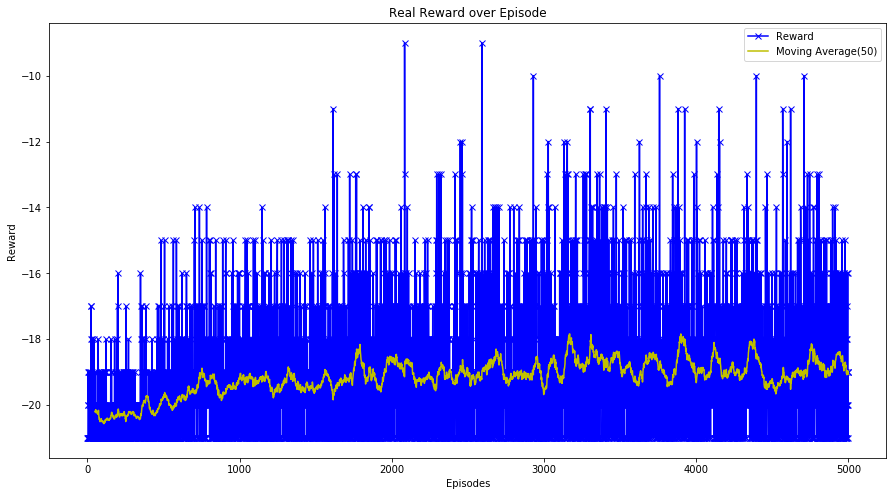

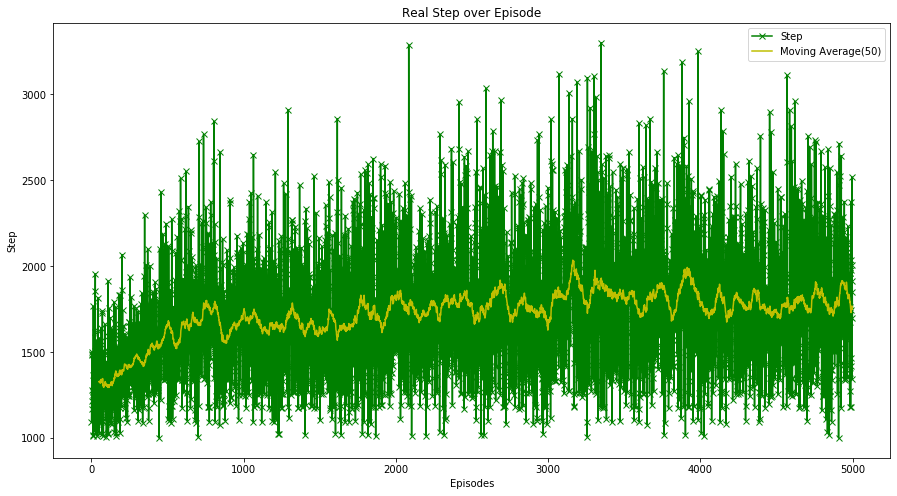

In [12]:
def plot_graph(cumulative_array, Reward_Step, num_aver_line,colour):
    plt.figure(figsize = (15,8))
    plt.plot(cumulative_array, color=colour,label=Reward_Step, marker='x')
    plt.title('Real {} over Episode'.format(Reward_Step))
    plt.xlabel('Episodes')
    plt.ylabel('{}'.format(Reward_Step))
    # Take 100 episode averages and plot them too
    if len(cumulative_array) >= num_aver_line:
        mean=[]
        for _ in range(num_aver_line):
            mean.append(None)
        for i in range(num_aver_line, len(cumulative_array)):
            means = np.array(cumulative_array)[i-num_aver_line:i].mean()
            mean.append(means)
        plt.plot(mean, color='y',label='Moving Average({})'.format(num_aver_line))
    plt.legend()
    plt.show()

plot_graph(cum_rewards,'Reward',50,'blue')
plot_graph(cum_steps,'Step',50,'green')

### Plot of Discounted rewards

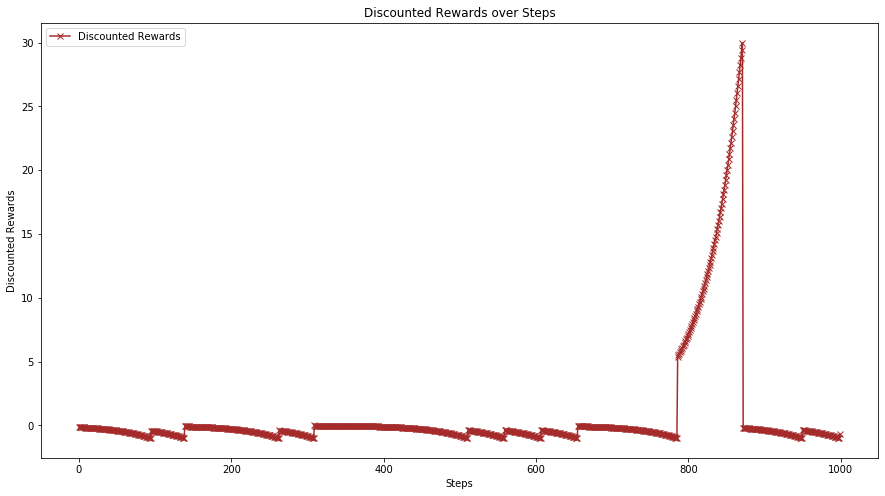

In [13]:
k = []
h = []
for i in range(1000):
    k_ =  memory.memory[-i][3]
    k.append(k_)
for c in reversed(k):
    h.append(c)
plt.figure(figsize = (15,8))
plt.plot(h, color='brown',label='Discounted Rewards',marker='x')
plt.title('Discounted Rewards over Steps')
plt.xlabel('Steps')
plt.ylabel('Discounted Rewards')
plt.legend()
plt.show()

### Save and Load Model

In [15]:
#Save Model
save_name = 'v6_linear_0003_reward30'
torch.save({
    'policy_net': policy_net.state_dict(),
    'target_net': target_net.state_dict(),
    'optimizer': optimizer.state_dict()
}, save_name + '.pt')


In [ ]:
#Load Model
save_name = 'trail'
checkpoint = torch.load(save_name + '.pt')
policy_net = DQN(screen_height, screen_width,
                 config.conv_layer_settings, config.dueling).to(device)
policy_net.load_state_dict(checkpoint['policy_net'])
policy_net.eval()

### Testing

In [16]:
#### Testing
num_episodes_test = 50
cum_rewards_=[]
for i_episode in range(num_episodes_test):
    # Initialize the environment and state
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    rewards = 0
    time_t = 0
    for t in count():
        # Select and perform an action
        action = policy_net(state).max(1)[1]
        _, reward, done, _ = env.step(action+2)
        rewards += reward
            
        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None
        # Move to the next state
        state = next_state

        if done:
            time_t = t
            break
    print('Episode:{}/{}, Rewards={}, Steps = {}'.format(i_episode+1,num_episodes_test,rewards, time_t))
    cum_rewards_.append(rewards)

Episode:1/10, Rewards=-15.0, Steps = 2286
Episode:2/10, Rewards=-15.0, Steps = 2493
Episode:3/10, Rewards=-19.0, Steps = 1849
Episode:4/10, Rewards=-21.0, Steps = 1741
Episode:5/10, Rewards=-19.0, Steps = 2491
Episode:6/10, Rewards=-21.0, Steps = 2220
Episode:7/10, Rewards=-20.0, Steps = 1477
Episode:8/10, Rewards=-17.0, Steps = 2165
Episode:9/10, Rewards=-15.0, Steps = 2429
Episode:10/10, Rewards=-15.0, Steps = 2259


### Show one Episode of the game after training

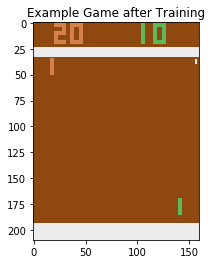

In [17]:
env.reset()
last_screen = get_screen()
current_screen = get_screen()
state = current_screen - last_screen
for t in count():
    clear_output(wait=True)
    # Select and perform an action
    action = policy_net(state).max(1)[1]
    screen, reward, done, _ = env.step(action+2)
    
    plt.imshow(screen,interpolation='none')
    plt.title('Example Game after Training')
    plt.show()        
    
    # Observe new state
    last_screen = current_screen
    current_screen = get_screen()
    if not done:
        next_state = current_screen - last_screen
    else:
        next_state = None
    # Move to the next state
    state = next_state
    sleep(0.0001)
    if done:
        break